<a href="https://colab.research.google.com/github/ShriramGithub7/EVA8-Assignment-4/blob/main/EVA8_Session_4_Step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target, Results, Analysis

Target:

  - Change the input and output channel size
  - Add dropout at each layer and also change the value from 0.25 to 0.1
  - Add rotation 
  - Add Learning Rate scheduler 

Results:
  - Parameters: 9,696
  - Best training Accuracy: 98.36%
  - Best Test Accuracy: 99.26%

Analysis:
  - Model has achied required parameters of under 10k
  - Model is underfitting as training accuracy is much less than test accuracy
  - Model has consistntly achieved accuracy around 99.25 but not 99.40%

# Import libraries

In [93]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function


# Find mean and std deviation of the data

In [94]:
testing_transofrms = transforms.Compose([transforms.ToTensor()])
exp= datasets.MNIST('.data/', train=True, download=True, transform=testing_transofrms)
exp_data = exp.train_data
exp_data=exp.transform(exp_data.numpy())


In [95]:
print('shape - ', exp_data.shape)
print('size - ', exp_data.size())
print('min - ', exp_data.min())
print('max - ', exp_data.max())
print('mean - ', exp_data.mean())
print('std - ', exp_data.std())
print('var - ', exp_data.var())

shape -  torch.Size([28, 60000, 28])
size -  torch.Size([28, 60000, 28])
min -  tensor(0.)
max -  tensor(1.)
mean -  tensor(0.1307)
std -  tensor(0.3081)
var -  tensor(0.0949)


# Data transformation

In [96]:
#training data transormation

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(255,))
                                      ])

#testing data transformation
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

# Load data, split it in train/test and apply transform 

In [97]:
train = datasets.MNIST('.data/', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('.data/', train=False, download = True, transform=test_transforms)

# Dataloader arguments and Train/Test Dataloaders

In [98]:
from torch.utils.data import dataloader
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available - ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader=torch.utils.data.DataLoader(train, **dataloader_args)

test_loader=torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available -  False


# View few images

torch.Size([64, 1, 28, 28])
torch.Size([64])


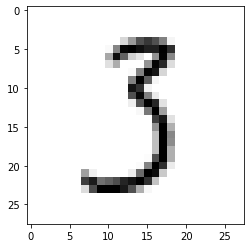

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

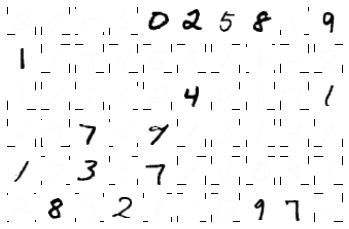

In [135]:
figure = plt.figure()
num_of_images=60
for index in range (1, num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')



# Build the model

In [110]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.container import Sequential
dropout = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Input block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=0, bias=False), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout)  
        ) #Output - 26*26

        #Convolution Block
        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 20, 3, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout)              
        ) #Output - 24*24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(20, 10, 3, padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout)                
        ) #Output - 22*22

        #Transaction Block
        self.pool1 = nn.MaxPool2d(2, 2)   #Output - 11*11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(10, 20, 1, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout)                
        ) #Output - 11*11

        #Convolution Block-2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(20, 10, 3, padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout)                
        ) #Output - 9*9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout)                
        ) #Output - 7*7

        #Output block
        self.convblock7 = nn.Sequential(
            nn.Conv2d(16, 8, 3, padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout)                
        ) #Output - 5*5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(8, 10, 1, padding=0, bias=False),  
        ) #Output - 5*5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) #Output - 1*1


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [103]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


In [104]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           2,880
       BatchNorm2d-6           [-1, 20, 24, 24]              40
              ReLU-7           [-1, 20, 24, 24]               0
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,800
      BatchNorm2d-10           [-1, 10, 22, 22]              20
             ReLU-11           [-1, 10, 22, 22]               0
          Dropout-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14           [-1, 20,

# Training and Testing

In [105]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train the model

In [107]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13825227320194244 Batch_id=937 Accuracy=83.05: 100%|██████████| 938/938 [02:07<00:00,  7.37it/s]



Test set: Average loss: 0.0976, Accuracy: 9740/10000 (97.40%)

EPOCH: 1


Loss=0.11746853590011597 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [02:05<00:00,  7.48it/s]



Test set: Average loss: 0.0532, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.0432295948266983 Batch_id=937 Accuracy=97.10: 100%|██████████| 938/938 [01:57<00:00,  8.00it/s]



Test set: Average loss: 0.0670, Accuracy: 9782/10000 (97.82%)

EPOCH: 3


Loss=0.3325256109237671 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [01:57<00:00,  7.97it/s]



Test set: Average loss: 0.0356, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.11230200529098511 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [01:58<00:00,  7.93it/s]



Test set: Average loss: 0.0293, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.02399774268269539 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [01:58<00:00,  7.89it/s]



Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.010569313541054726 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [02:00<00:00,  7.80it/s]



Test set: Average loss: 0.0287, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.021402468904852867 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:58<00:00,  7.92it/s]



Test set: Average loss: 0.0276, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.07834212481975555 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [01:57<00:00,  7.95it/s]



Test set: Average loss: 0.0292, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.020499058067798615 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [01:57<00:00,  7.98it/s]



Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.10734590142965317 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [01:58<00:00,  7.91it/s]



Test set: Average loss: 0.0269, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.006398530676960945 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [01:59<00:00,  7.86it/s]



Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.08315370231866837 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [01:57<00:00,  7.98it/s]



Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.017716728150844574 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [01:58<00:00,  7.92it/s]



Test set: Average loss: 0.0262, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.010600335896015167 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [02:00<00:00,  7.80it/s]



Test set: Average loss: 0.0270, Accuracy: 9922/10000 (99.22%)



# Plot graphs

Text(0.5, 1.0, 'Test Accuracy')

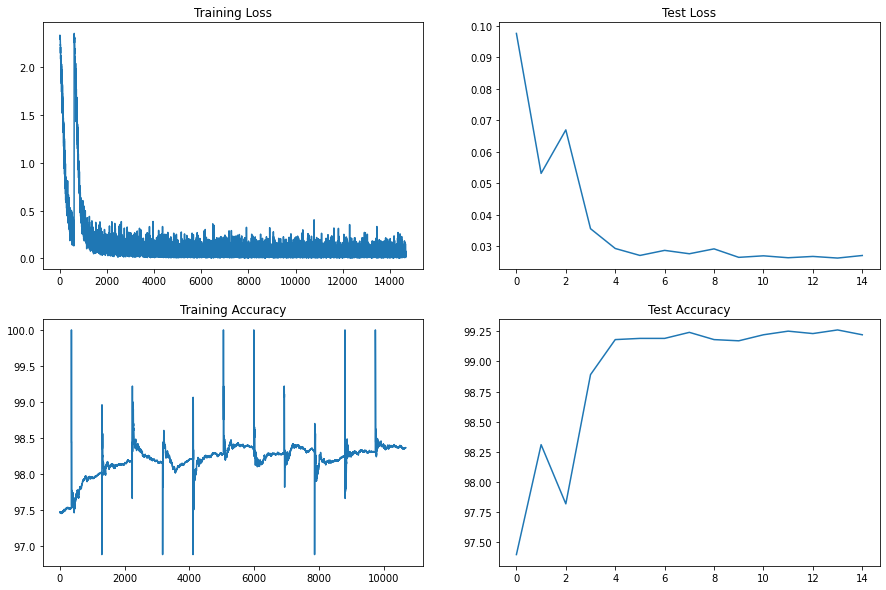

In [108]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")